<a href="https://colab.research.google.com/github/dora-jpg/Vaccine-Sentiment-Classifier/blob/main/AI2_HM3_bidirectional_RNN_with_LSTM_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Artificial Intelligence II - Homework 3
# 💉Vaccine sentiment classifier using bidirectional Recursive Neural Networks with LSTM/GRU.

In this exercise we are going to develop a vaccine sentiment classifier that classifies tweets in pro-vax, anti-vax and neutral classes using bidirectional Recursive Neural Networks. I experimented with LSTM and GRU.
For data preprocessing and feature extracting I experimented with a GloVe pretrained model. I used a simple preprocessing funtion that removes puctuation, html tags and urls. I kept emojis because I noticed that some of them are included in the pretrained glove model. I used the glove.twitter.27B.200d (in Homework 2 I used the glove.twitter.27B.50d). For exercise 2 I added an attention parameter to all implemented models that can be set True to activate it.


**Note:** 
I seeded numpy.random and torch.random in the cells that define each model so that I get the same results in every run and can compare scores.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Libraries and Read Datasets

Import libraries that will be used in this notebook, define a seeding function and set device to cuda if available.


In [2]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os

import numpy as np
import pandas as pd
import math

# Evaluation metrics
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

import matplotlib.pyplot as plt
%matplotlib inline
import sklearn.metrics
import seaborn as sns
import random
import sys
from IPython.display import Image

# for text preprocessing
import re
import string
from nltk.corpus import stopwords
import nltk
nltk.download("stopwords")
nltk.download('punkt')
from nltk import word_tokenize

# Batches
!pip install torchtext
from torchtext import vocab
from torchtext.legacy.data import Field,Dataset,LabelField,BucketIterator
from torchtext.legacy.data import Dataset, Example

# Learning curves
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

# Confusion Matrix
from sklearn.metrics import ConfusionMatrixDisplay


def set_seed(seed = 1234):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    !CUBLAS_WORKSPACE_CONFIG=:4096:2 # for cuda deterministic behavior
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.enabled = False
    torch.backends.cudnn.benchmark = False
    # torch.use_deterministic_algorithms(False)
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed()

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('Working on:', device)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
Working on: cuda


Read train and validation datasets.

In [3]:
df_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Artificial Intelligence II/vaccine_train_set.csv")
df_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Artificial Intelligence II/vaccine_validation_set.csv")

 We don't need the first column of the datasets because it is an index.

In [4]:
# get rid of first column
df_train = df_train.iloc[: , 1:]
df_test = df_test.iloc[: , 1:]

In [5]:
display(df_train.head())

,tweet,label
0,Sip N Shop Come thru right now #Marjais #Popul...,0
1,I don't know about you but My family and I wil...,1
2,@MSignorile Immunizations should be mandatory....,2
3,President Obama spoke in favor of vaccination ...,0
4,"""@myfoxla: Arizona monitoring hundreds for mea...",0


In [6]:
display(df_test.head())

,tweet,label
0,@user They had a massive surge in with covid d...,1
1,Required vaccines for school: Parents and guar...,0
2,“@KCStar: Two more Johnson County children hav...,0
3,NV can do better. Which states are the best (a...,2
4,Nothing like killing ourselves w/ our own fear...,2


# Data Pre-processing

## Data Cleaning


Cleaning involves convertion to lowercase, removal of urls, html tags, punctuation and stopwords. As a explained in the introduction, I decided to keep the emojis as they can show sentiment. 

In [7]:
stop_words = stopwords.words("english")

def tweets_cleaning(x, remove_emojis=False, remove_stop_words=True):
    """Apply function to a clean a tweet"""
    x = x.lower().strip()
    # romove urls
    url = re.compile(r'https?://\S+|www\.\S+')
    x = url.sub(r'',x)
    # remove html tags
    html = re.compile(r'<.*?>')
    x = html.sub(r'',x)
    # remove punctuation
    operator = str.maketrans(' ',' ',string.punctuation)
    x = x.translate(operator)
    if remove_emojis:
        x = x.encode('ascii', 'ignore').decode('utf8').strip()
    if remove_stop_words:
        x = ' '.join([word for word in x.split(' ') if word not in stop_words])
    return x

In [8]:
## APPLY the cleaning function to the text column
df_train['clean_tweet'] = df_train['tweet'].apply(tweets_cleaning)
df_test['clean_tweet'] = df_test['tweet'].apply(tweets_cleaning)

In [9]:
Y_train = df_train['label'] #Only keep value
Y_test = df_test['label'] #Only keep value

In [10]:
df_train['clean_tweet']

0        sip n shop come thru right marjais popularnobo...
1        dont know family take covid19 vaccine anytime ...
2        msignorile immunizations mandatory period okla...
3        president obama spoke favor vaccination childr...
4        myfoxla arizona monitoring hundreds measles li...
                               ...                        
15971    salon u believe antivax nutcases caused measle...
15972    feel parents dont vaccinate kids\r\n\r\nmeasle...
15973          70 preschoolers tested measles simi valley 
15974    finance minister budget offers room procure co...
15975    date vaccines take cdc’s vaccine quiz find vac...
Name: clean_tweet, Length: 15976, dtype: object

In [11]:
df_train['clean_tweet']

0        sip n shop come thru right marjais popularnobo...
1        dont know family take covid19 vaccine anytime ...
2        msignorile immunizations mandatory period okla...
3        president obama spoke favor vaccination childr...
4        myfoxla arizona monitoring hundreds measles li...
                               ...                        
15971    salon u believe antivax nutcases caused measle...
15972    feel parents dont vaccinate kids\r\n\r\nmeasle...
15973          70 preschoolers tested measles simi valley 
15974    finance minister budget offers room procure co...
15975    date vaccines take cdc’s vaccine quiz find vac...
Name: clean_tweet, Length: 15976, dtype: object

Overview of label distribution

In [12]:
print("train data")
print("label 0:",Y_train[Y_train== 0].count())
print("label 1:",Y_train[Y_train== 1].count())
print("label 2:",Y_train[Y_train== 2].count())
print("validation data")
print("label 0:",Y_test[Y_test== 0].count())
print("label 1:",Y_test[Y_test== 1].count())
print("label 2:",Y_test[Y_test== 2].count())

train data
label 0: 7458
label 1: 2073
label 2: 6445
validation data
label 0: 1065
label 1: 296
label 2: 921


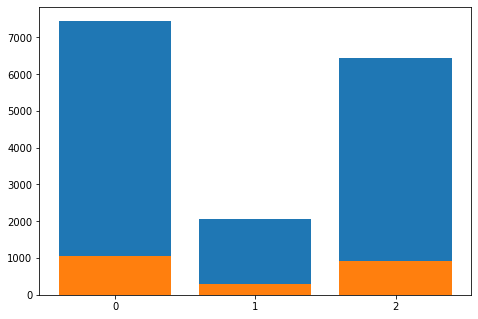

In [13]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = ['0', '1', '2']
train = [Y_train[Y_train== 0].count(),Y_train[Y_train== 1].count(),Y_train[Y_train== 2].count()]
test= [Y_test[Y_test== 0].count(),Y_test[Y_test== 1].count(),Y_test[Y_test== 2].count()]
ax.bar(labels, train)
ax.bar(labels, test)
plt.show()

Label 1 has very few instances so we expect that it has a lower score than the other 2 labels. 

# Features Extraction


## GloVe representation

### First Approach: Create fixed size vectors for glove

Load pre-trained GloVe vectors into a dictionary.

In [14]:
embeddings_dict = {}
with open("/content/drive/MyDrive/Colab Notebooks/Artificial Intelligence II/glove.twitter.27B.200d.txt.gz (Unzipped Files)/glove.twitter.27B.200d.txt", 'r', encoding="utf-8") as f:
  for line in f:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:],'float32')
    embeddings_dict[word]=vector

Find the vector for each word in each tweet. If the tweet has more words than the number specified by `padding` then cut the tweet there. If it has less words than `padding` number then add vectors with zeros. 

In [15]:
def find_glove(text, padding=31):
  tokens = word_tokenize(text.lower())
  res = [ embeddings_dict[token] for token in tokens if (token in embeddings_dict) ]
  res = res[:padding]
  if len(res)<padding:
    for i in range(padding-len(res)):
      res.append(np.zeros(200))
  return res

df_train['features'] = df_train['clean_tweet'].apply(find_glove)
df_test['features'] = df_test['clean_tweet'].apply(find_glove)
df_train['features']

0        [[-0.16063, -0.28647, -0.60789, 0.42767, -0.11...
1        [[-0.33784, 0.54451, -0.1921, 0.43394, -0.4804...
2        [[-0.33915, -0.28546, -0.26841, 0.014209, 0.23...
3        [[0.34601, 0.30425, -0.098192, 0.08868, -0.359...
4        [[0.2101, -0.21056, -0.36659, -0.37312, 0.0773...
                               ...                        
15971    [[0.15358, -0.30126, -0.3615, 0.24909, 0.72131...
15972    [[0.061424, 0.42365, -0.13984, 0.26585, -0.215...
15973    [[0.058755, 0.018929, 0.24508, 0.021967, -0.23...
15974    [[0.14571, -0.31397, -0.39098, -0.16087, -0.02...
15975    [[-0.48751, 0.11036, 0.16039, -0.15214, -0.217...
Name: features, Length: 15976, dtype: object

# Bidirectional RNN

## Fixed length of the sequences

A model that takes fixed size vectors as input.

In [16]:
class BRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, cell, dropout=0.3, attention=True):
        super(BRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.cell = cell
        self.bidirectional = True
        self.attention = attention
        self.scale = 1. / math.sqrt(hidden_size)
        if (cell == 'LSTM'):
          self.rnn = nn.LSTM(
              input_size, hidden_size, num_layers, batch_first=True, bidirectional=True, dropout=dropout
          )
        else:
          self.rnn = nn.GRU(
              input_size, hidden_size, num_layers, batch_first=True, bidirectional=True, dropout=dropout
          )
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):

        if (self.cell == 'LSTM'):
          out, hidden = self.rnn(x)
          hidden = hidden[1]
        else:
          out, hidden = self.rnn(x)

        if (self.attention==True):
            # print("hi")
            if (self.bidirectional==True):
                hidden = torch.cat([hidden[-1], hidden[-2]], dim=1) # concatinate the last 2 hidden cells (backward & forward)
            else:
                hidden = hidden[-1]

            query = hidden.unsqueeze(1) # [BxQ] -> [Bx1xQ]
            values = out
            # print("query", query.shape)
            # print("keys", keys.shape)
            # keys = out.transpose(1,2) # [BxTxK] -> [BxKxT]
            # print("keys", keys.shape)
            attention_scores = torch.bmm(query, out.transpose(1,2)) # [Bx1xQ]x[BxKxT] -> [Bx1xT]
            attention_distribution = F.softmax(attention_scores.mul_(self.scale), dim=2) # scale, normalize

            # out = out # [TxBxV] -> [BxTxV]
            # print("values", values.shape)
            out = torch.bmm(attention_distribution, out).squeeze(1) #[Bx1xT]x[BxTxV] -> [BxV]

            out = self.fc(out)
        else:
            out = self.fc(out[:, -1, :])
        
        return out

For skip connections, I had to re-define the model to keep the output of each layer of the stacked rnn.

In [17]:
class skipBRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, cell, dropout=0.3, attention=True):
        super(skipBRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.cell = cell
        self.dropout = nn.Dropout(p=dropout)
        self.attention = attention
        self.bidirectional = True
        self.scale = 1. / math.sqrt(hidden_size)
        
        if (cell == 'LSTM'):
            rnn = nn.LSTM
        else:
            rnn = nn.GRU

        self.rnns = nn.ModuleList()
        for i in range(num_layers):
            input_size = input_size if i == 0 else hidden_size*2
            self.rnns.append(rnn(input_size, hidden_size, 1, batch_first=True, bidirectional=True))
        
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):

        sent_variable = x

        for i in range(self.num_layers):
            if i != 0:
                sent_variable = self.dropout(sent_variable.detach())

            out, hidden = self.rnns[i](sent_variable.detach())
            hidden = hidden[1]

            if i == 0:
                sent_variable = out.detach()

            sent_variable = torch.cat((sent_variable,out.detach()),dim=1)

        if (self.attention==True):
            # print("hi")
            if (self.bidirectional==True):
                hidden = torch.cat([hidden[-1], hidden[-2]], dim=1) # concatinate the last 2 hidden cells (backward & forward)
            else:
                hidden = hidden[-1]

            query = hidden.unsqueeze(1) # [BxQ] -> [Bx1xQ]
            values = out

            attention_scores = torch.bmm(query, out.transpose(1,2)) # [Bx1xQ]x[BxKxT] -> [Bx1xT]
            attention_distribution = F.softmax(attention_scores.mul_(self.scale), dim=2) # scale, normalize

            out = torch.bmm(attention_distribution, out).squeeze(1) #[Bx1xT]x[BxTxV] -> [BxV]

            out = self.fc(out)
        else:
            out = self.fc(out[:, -1, :])

        return out

Create tensors and a train dataset to pass to dataloader.


In [67]:
x = torch.tensor(np.stack(df_train['features'], axis=0), dtype=torch.float)
y = torch.tensor(np.stack(df_train['label'], axis=0), dtype=torch.long)

print(f"x shape: {x.shape}")
print(f"y shape: {y.shape}")

dataset = torch.utils.data.TensorDataset(x, y)

x_test = torch.tensor(np.stack(df_test['features'], axis=0), dtype=torch.float)
y_test = torch.tensor(np.stack(df_test['label'], axis=0), dtype=torch.long)

print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")


x shape: torch.Size([15976, 31, 200])
y shape: torch.Size([15976])
x_test shape: torch.Size([2282, 31, 200])
y_test shape: torch.Size([2282])


### Train and evaluation function

In [148]:
def train(model, learning_rate, dataset, batch_size, epochs, x_test, y_test, device):
    x_test = x_test.to(device=device).squeeze(1)
    y_test = y_test.to(device=device)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    epoch_loss = []
    validation_loss = []
    f1 = []

    # Train Network
    train_loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    for epoch in range(epochs):
        model.train()
        batch_losses = []
        for batch_idx, (data, targets) in enumerate(train_loader):
            # Get data to cuda if possible
            data = data.to(device=device).squeeze(1)
            targets = targets.to(device=device)

            # forward
            scores = model(data)
            loss = criterion(scores, targets)

            batch_losses.append(loss.item())

            # backward
            optimizer.zero_grad()
            loss.backward()

            # Clip params
            for param in model.parameters():
                if param.grad is None:
                    continue
                grad_val = torch.clamp(param.grad, -5, 5)

            # gradient descent or adam step
            optimizer.step()
            
        epoch_loss.append(sum(batch_losses)/len(train_loader))
        model.eval()
        with torch.no_grad():
            y_test_pred = model(x_test)

        val_loss = criterion(y_test_pred, y_test)

        validation_loss.append(val_loss.item())
        f1score = f1_score(y_test.cpu(), y_test_pred.max(1)[1].cpu(), average='micro')
        f1.append(f1score)
        print(f"Epoch {epoch:3}: Training Loss = {sum(batch_losses)/len(train_loader):.5f}  Validation Loss = {validation_loss[epoch]:.5f} f1= {f1score:.5f}")

    model.eval()

    with torch.no_grad():
        scores = model(x_test)
        _, y_pred = scores.max(1)

    if device==torch.device("cuda"):
        y_pred = y_pred.cpu()
    
    print("")
    precision, recall, f1, support = precision_recall_fscore_support(Y_test, y_pred)
    print(f"         precision\t  recall\t   f1\t    \tsupport")
    print(f"---------------------------------------------------------------")
    print(f"label 0 | {precision[0]*100:0.4f}\t {recall[0]*100:0.4f}\t {f1[0]*100:0.4f}\t {support[0]}")
    print(f"label 1 | {precision[1]*100:.4f}\t {recall[1]*100:.4f}\t {f1[1]*100:2.4f}\t {support[1]}")
    print(f"label 2 | {precision[2]*100:0.4f}\t {recall[2]*100:0.4f}\t {f1[2]*100:0.4f}\t {support[2]}")

    average = precision_recall_fscore_support(Y_test, y_pred, average='micro')
    print(f"micro   | {average[0]*100:0.4f}\t {average[1]*100:0.4f}\t {average[2]*100:0.4f}\t -")

    return epoch_loss, validation_loss, y_pred, scores, f1

### Experimentation



In [91]:
set_seed() # for model and dataloader

# Hyperparameters
input_size = 200
num_layers = 2
hidden_size = 32
num_classes = 3
batch_size = 128
cell = 'LSTM'
dropout = 0.3

epochs = 3
learning_rate = 0.01

# Initialize network
model = BRNN(input_size, hidden_size, num_layers, num_classes, cell, dropout=dropout, attention=True).to(device)
epoch_loss, validation_loss, y_pred, scores, f1 = train(model, learning_rate, dataset, batch_size, epochs, x_test, y_test, device)

Epoch   0: Training Loss = 0.76256  Validation Loss = 0.68623 f1= 0.70377
Epoch   1: Training Loss = 0.64724  Validation Loss = 0.66522 f1= 0.70684
Epoch   2: Training Loss = 0.57245  Validation Loss = 0.67380 f1= 0.71472

         precision	  recall	   f1	    	support
---------------------------------------------------------------
label 0 | 82.1772	 72.3005	 76.9231	 1065
label 1 | 54.1502	 46.2838	 49.9089	 296
label 2 | 66.3004	 78.6102	 71.9324	 921
micro   | 71.4724	 71.4724	 71.4724	 -


Adding 1 layer. We observe better result.

In [92]:
set_seed() # for model and dataloader

# Hyperparameters
input_size = 200
num_layers = 3
hidden_size = 32
num_classes = 3
batch_size = 128
cell = 'LSTM'
dropout = 0.3

epochs = 3
learning_rate = 0.01

# Initialize network
model = BRNN(input_size, hidden_size, num_layers, num_classes, cell, dropout=dropout, attention=True).to(device)
epoch_loss, validation_loss, y_pred, scores, f1 = train(model, learning_rate, dataset, batch_size, epochs, x_test, y_test, device)

Epoch   0: Training Loss = 0.79116  Validation Loss = 0.71961 f1= 0.68230
Epoch   1: Training Loss = 0.66653  Validation Loss = 0.68966 f1= 0.70421
Epoch   2: Training Loss = 0.60277  Validation Loss = 0.66701 f1= 0.71911

         precision	  recall	   f1	    	support
---------------------------------------------------------------
label 0 | 78.1735	 80.3756	 79.2593	 1065
label 1 | 52.8384	 40.8784	 46.0952	 296
label 2 | 69.3111	 72.0955	 70.6759	 921
micro   | 71.9106	 71.9106	 71.9106	 -


Add a layer and 2 epochs. We see that the 2 more epochs overfit because the validation loss and f1 score get worse.

In [93]:
set_seed() # for model and dataloader

# Hyperparameters
input_size = 200
num_layers = 3
hidden_size = 32
num_classes = 3
batch_size = 128
cell = 'LSTM'
dropout = 0.3

epochs = 5
learning_rate = 0.01

# Initialize network
model = BRNN(input_size, hidden_size, num_layers, num_classes, cell, dropout=dropout, attention=True).to(device)
epoch_loss, validation_loss, y_pred, scores, f1 = train(model, learning_rate, dataset, batch_size, epochs, x_test, y_test, device)

Epoch   0: Training Loss = 0.79116  Validation Loss = 0.71961 f1= 0.68230
Epoch   1: Training Loss = 0.66653  Validation Loss = 0.68966 f1= 0.70421
Epoch   2: Training Loss = 0.60277  Validation Loss = 0.66701 f1= 0.71911
Epoch   3: Training Loss = 0.53511  Validation Loss = 0.72830 f1= 0.70508
Epoch   4: Training Loss = 0.48418  Validation Loss = 0.69365 f1= 0.70771

         precision	  recall	   f1	    	support
---------------------------------------------------------------
label 0 | 81.1975	 72.5822	 76.6485	 1065
label 1 | 64.3357	 31.0811	 41.9134	 296
label 2 | 63.1845	 81.4332	 71.1575	 921
micro   | 70.7713	 70.7713	 70.7713	 -


In [99]:
set_seed() # for model and dataloader

# Hyperparameters
input_size = 200
num_layers = 3
hidden_size = 64
num_classes = 3
batch_size = 64
cell = 'LSTM'
dropout = 0.3

epochs = 7
learning_rate = 0.01

# Initialize network
model = BRNN(input_size, hidden_size, num_layers, num_classes, cell, dropout=dropout, attention=True).to(device)
epoch_loss, validation_loss, y_pred, scores, f1 = train(model, learning_rate, dataset, batch_size, epochs, x_test, y_test, device)

Epoch   0: Training Loss = 0.78193  Validation Loss = 0.69781 f1= 0.69588
Epoch   1: Training Loss = 0.67241  Validation Loss = 0.66963 f1= 0.71604
Epoch   2: Training Loss = 0.60178  Validation Loss = 0.68732 f1= 0.71341
Epoch   3: Training Loss = 0.53395  Validation Loss = 0.71796 f1= 0.70727
Epoch   4: Training Loss = 0.47705  Validation Loss = 0.75833 f1= 0.70508
Epoch   5: Training Loss = 0.42783  Validation Loss = 0.76688 f1= 0.70158
Epoch   6: Training Loss = 0.37917  Validation Loss = 0.79579 f1= 0.70070

         precision	  recall	   f1	    	support
---------------------------------------------------------------
label 0 | 78.0488	 75.1174	 76.5550	 1065
label 1 | 47.6048	 53.7162	 50.4762	 296
label 2 | 69.3391	 69.4897	 69.4143	 921
micro   | 70.0701	 70.0701	 70.0701	 -


"Best" parameters but with skip connections. I will make the network larger as skip connections are better for large networks and to train a larger network we need more epochs.

In [103]:
set_seed() # for model and dataloader

# Hyperparameters
input_size = 200
num_layers = 5
hidden_size = 64
num_classes = 3
batch_size = 128
cell = 'LSTM'
dropout = 0.3

epochs = 7
learning_rate = 0.01

# Initialize network
model = skipBRNN(input_size, hidden_size, num_layers, num_classes, cell, dropout=dropout, attention=True).to(device)
epoch_loss, validation_loss, y_pred, scores, f1 = train(model, learning_rate, dataset, batch_size, epochs, x_test, y_test, device)

Epoch   0: Training Loss = 0.91019  Validation Loss = 0.82296 f1= 0.63059
Epoch   1: Training Loss = 0.82625  Validation Loss = 0.77451 f1= 0.64549
Epoch   2: Training Loss = 0.80460  Validation Loss = 0.75565 f1= 0.66170
Epoch   3: Training Loss = 0.77872  Validation Loss = 0.74421 f1= 0.66214
Epoch   4: Training Loss = 0.77041  Validation Loss = 0.72384 f1= 0.67485
Epoch   5: Training Loss = 0.75888  Validation Loss = 0.73678 f1= 0.65294
Epoch   6: Training Loss = 0.75080  Validation Loss = 0.72357 f1= 0.68011

         precision	  recall	   f1	    	support
---------------------------------------------------------------
label 0 | 77.7669	 74.5540	 76.1266	 1065
label 1 | 47.6744	 27.7027	 35.0427	 296
label 2 | 62.0753	 73.3985	 67.2637	 921
micro   | 68.0105	 68.0105	 68.0105	 -


"Best" parameters but without attention.

We observe that it doesn't learn label 1 at all. The improvement in the version with attention is significant.

In [106]:
set_seed() # for model and dataloader

# Hyperparameters
input_size = 200
num_layers = 3
hidden_size = 32
num_classes = 3
batch_size = 128
cell = 'LSTM'
dropout = 0.3

epochs = 3
learning_rate = 0.01

# Initialize network
model = BRNN(input_size, hidden_size, num_layers, num_classes, cell, dropout=dropout, attention=False).to(device)
epoch_loss, validation_loss, y_pred, scores, f1 = train(model, learning_rate, dataset, batch_size, epochs, x_test, y_test, device)

Epoch   0: Training Loss = 0.88929  Validation Loss = 0.78293 f1= 0.65513
Epoch   1: Training Loss = 0.77012  Validation Loss = 0.76495 f1= 0.66696
Epoch   2: Training Loss = 0.73001  Validation Loss = 0.74068 f1= 0.68273

         precision	  recall	   f1	    	support
---------------------------------------------------------------
label 0 | 81.4050	 73.9906	 77.5209	 1065
label 1 | 0.0000	 0.0000	 0.0000	 296
label 2 | 58.5997	 83.6048	 68.9038	 921
micro   | 68.2734	 68.2734	 68.2734	 -


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Let's try 2 layers and a larger hidden_size.

In [113]:
set_seed() # for model and dataloader

# Hyperparameters
input_size = 200
num_layers = 2
hidden_size = 128
num_classes = 3
batch_size = 128
cell = 'LSTM'
dropout = 0.3

epochs = 5
learning_rate = 0.01

# Initialize network
model = BRNN(input_size, hidden_size, num_layers, num_classes, cell, dropout=dropout, attention=False).to(device)
epoch_loss, validation_loss, y_pred, scores, f1 = train(model, learning_rate, dataset, batch_size, epochs, x_test, y_test, device)

Epoch   0: Training Loss = 0.98590  Validation Loss = 0.94963 f1= 0.54207
Epoch   1: Training Loss = 0.82077  Validation Loss = 0.74600 f1= 0.66608
Epoch   2: Training Loss = 0.71422  Validation Loss = 0.70798 f1= 0.68405
Epoch   3: Training Loss = 0.65371  Validation Loss = 0.72892 f1= 0.68011
Epoch   4: Training Loss = 0.60167  Validation Loss = 0.69840 f1= 0.70026

         precision	  recall	   f1	    	support
---------------------------------------------------------------
label 0 | 76.6423	 78.8732	 77.7418	 1065
label 1 | 50.6608	 38.8514	 43.9771	 296
label 2 | 67.0490	 69.8154	 68.4043	 921
micro   | 70.0263	 70.0263	 70.0263	 -


Let's try 2 layers and a larger hidden_size.

In [116]:
set_seed() # for model and dataloader

# Hyperparameters
input_size = 200
num_layers = 2
hidden_size = 256
num_classes = 3
batch_size = 256
cell = 'LSTM'
dropout = 0.2

epochs = 8
learning_rate = 0.01

# Initialize network
model = BRNN(input_size, hidden_size, num_layers, num_classes, cell, dropout=dropout, attention=False).to(device)
epoch_loss, validation_loss, y_pred, scores, f1 = train(model, learning_rate, dataset, batch_size, epochs, x_test, y_test, device)

Epoch   0: Training Loss = 0.96748  Validation Loss = 0.80191 f1= 0.65118
Epoch   1: Training Loss = 0.77014  Validation Loss = 0.75083 f1= 0.67134
Epoch   2: Training Loss = 0.72127  Validation Loss = 0.71768 f1= 0.67572
Epoch   3: Training Loss = 0.64952  Validation Loss = 0.70514 f1= 0.68843
Epoch   4: Training Loss = 0.57107  Validation Loss = 0.71652 f1= 0.69457
Epoch   5: Training Loss = 0.49438  Validation Loss = 0.76070 f1= 0.69369
Epoch   6: Training Loss = 0.41721  Validation Loss = 0.81722 f1= 0.68317
Epoch   7: Training Loss = 0.34523  Validation Loss = 0.84297 f1= 0.69632

         precision	  recall	   f1	    	support
---------------------------------------------------------------
label 0 | 74.5027	 77.3709	 75.9097	 1065
label 1 | 57.6923	 40.5405	 47.6190	 296
label 2 | 66.6322	 70.0326	 68.2901	 921
micro   | 69.6319	 69.6319	 69.6319	 -


In [ ]:
set_seed() # for model and dataloader

# Hyperparameters
input_size = 200
num_layers = 3
hidden_size = 32
num_classes = 3
batch_size = 128
cell = 'LSTM'
dropout = 0.3

epochs = 3
learning_rate = 0.01

# Initialize network
model = BRNN(input_size, hidden_size, num_layers, num_classes, cell, dropout=dropout, attention=False).to(device)
epoch_loss, validation_loss, y_pred, scores, f1 = train(model, learning_rate, dataset, batch_size, epochs, x_test, y_test, device)

"Best" parameters but with skip connections and without attention.

In [ ]:
set_seed() # for model and dataloader

# Hyperparameters
input_size = 200
num_layers = 3
hidden_size = 32
num_classes = 3
batch_size = 128
cell = 'LSTM'
dropout = 0.3

epochs = 3
learning_rate = 0.01

# Initialize network
model = skipBRNN(input_size, hidden_size, num_layers, num_classes, cell, dropout=dropout, attention=False).to(device)
epoch_loss, validation_loss, y_pred, scores, f1 = train(model, learning_rate, dataset, batch_size, epochs, x_test, y_test, device)

Trying GRU.

In [117]:
set_seed() # for model and dataloader

# Hyperparameters
input_size = 200
num_layers = 3
hidden_size = 32
num_classes = 3
batch_size = 128
cell = 'GRU'
dropout = 0.3

epochs = 3
learning_rate = 0.01

# Initialize network
model = BRNN(input_size, hidden_size, num_layers, num_classes, cell, dropout=dropout, attention=True).to(device)
epoch_loss, validation_loss, y_pred, scores, f1 = train(model, learning_rate, dataset, batch_size, epochs, x_test, y_test, device)

Epoch   0: Training Loss = 0.76926  Validation Loss = 0.75763 f1= 0.64987
Epoch   1: Training Loss = 0.66705  Validation Loss = 0.67199 f1= 0.70727
Epoch   2: Training Loss = 0.59856  Validation Loss = 0.70829 f1= 0.70289

         precision	  recall	   f1	    	support
---------------------------------------------------------------
label 0 | 73.0579	 83.0047	 77.7143	 1065
label 1 | 57.7778	 35.1351	 43.6975	 296
label 2 | 69.0583	 66.8838	 67.9537	 921
micro   | 70.2892	 70.2892	 70.2892	 -


TypeError: ignored

In [152]:
def custom_grid_search(net, max_epochs = 8):
    dict_best = {}
    best_loss = 1.0
    best_f1 = 0
    dict_best_f1 = {}
    curr = {}

    for num_layers in [2,3,4]:
        curr['num_layers'] = num_layers
        for hidden_size in [32, 64, 128]:
            curr['hidden_size'] = hidden_size
            for batch_size in [64, 128]:
                curr['batch_size'] = batch_size
                for dropout in [0.0,0.1,0.2,0.3]:
                    curr['dropout'] = dropout
                    for attention in [False, True]:
                        curr['attention'] = attention
                        print(f"num_layers: {curr['num_layers']},hidden_size: {curr['hidden_size']}, batch_size: {curr['batch_size']}, dropout: {curr['dropout']}, attention: {curr['attention']}")
                        set_seed() # for model and dataloader
                        model = BRNN(input_size, hidden_size, num_layers, num_classes, cell, dropout=dropout, attention=attention).to(device)
                        _, validation_loss, _, _, f1score = train(model, learning_rate, dataset, batch_size, max_epochs, x_test, y_test, device)
                        indexloss = np.array(validation_loss).argmin()
                        indexf1 = np.array(f1score).argmin()
                        curr['epoch_f1'] = indexf1+1
                        curr['epoch_loss'] = indexloss+1
                        if (validation_loss[indexloss] < best_loss):
                            best_loss = validation_loss[indexloss]
                            dict_best = curr
                        print(f1score)
                        if (f1score[indexf1] > best_f1):
                            best_f1 = f1score[indexf1]
                            dict_best_f1 = curr
    # curr['num_layers'] = 1
    # curr['dropout'] = 0.0
    # for hidden_size in [32, 64, 128]:
    #     curr['hidden_size'] = hidden_size
    #     for batch_size in [64, 128]:
    #         curr['batch_size'] = batch_size
    #         for attention in [False, True]:
    #             curr['attention'] = attention
    #             print(f"num_layers: {curr['num_layers']},hidden_size: {curr['hidden_size']}, batch_size: {curr['batch_size']}, dropout: {curr['dropout']}, attention: {curr['attention']}")
    #             set_seed() # for model and dataloader
    #             model = BRNN(input_size, hidden_size, 1, num_classes, cell, dropout=0.0, attention=True).to(device)
    #             _, validation_loss, _, _, f1 = train(model, learning_rate, dataset, batch_size, max_epochs, x_test, y_test, device)
    #             index = np.array(validation_loss).argmin()
    #             if (validation_loss[index] < best_loss):
    #                 best_loss = validation_loss[index]
    #                 dict_best = curr
    
    return dict_best, best_loss, dict_best_f1, best_f1

In [ ]:
dict_best, best_loss, dict_best_f1, best_f1 = custom_grid_search(BRNN)

num_layers: 2,hidden_size: 32, batch_size: 64, dropout: 0.0, attention: False
Epoch   0: Training Loss = 0.81739  Validation Loss = 0.73163 f1= 0.67835
Epoch   1: Training Loss = 0.68705  Validation Loss = 0.70272 f1= 0.69544
Epoch   2: Training Loss = 0.62746  Validation Loss = 0.70856 f1= 0.69018
Epoch   3: Training Loss = 0.57834  Validation Loss = 0.72147 f1= 0.69106
Epoch   4: Training Loss = 0.52730  Validation Loss = 0.73543 f1= 0.69720
Epoch   5: Training Loss = 0.49105  Validation Loss = 0.75294 f1= 0.69150
Epoch   6: Training Loss = 0.45348  Validation Loss = 0.80627 f1= 0.68361
Epoch   7: Training Loss = 0.42916  Validation Loss = 0.83916 f1= 0.67660

         precision	  recall	   f1	    	support
---------------------------------------------------------------
label 0 | 78.1855	 72.0188	 74.9756	 1065
label 1 | 42.6573	 41.2162	 41.9244	 296
label 2 | 64.5320	 71.1183	 67.6653	 921
micro   | 67.6599	 67.6599	 67.6599	 -
[0.74975562 0.41924399 0.67665289]
num_layers: 2,hidden

In [ ]:
print(params, loss)

## Confusion Matrix

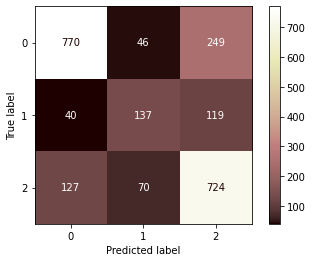

In [40]:
ConfusionMatrixDisplay.from_predictions(Y_test, y_pred, cmap=plt.cm.pink)  
plt.show()

## Learning Curves

[0.7625582237243652, 0.6472433953285217, 0.5724480683803559]
[0.6862345933914185, 0.6652163863182068, 0.6738044023513794]


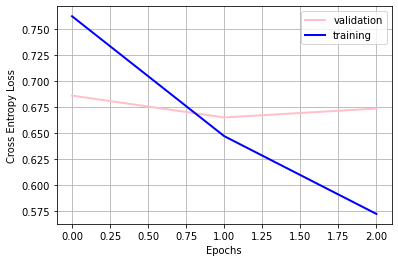

In [41]:
# plot
print(epoch_loss)
print(validation_loss)
fig, ax = plt.subplots()
ax.plot(np.arange(epochs), validation_loss, color="pink", lw=2, label='validation')
ax.plot(np.arange(epochs), epoch_loss, color="b", lw=2, label='training')

ax.set_xlabel('Epochs')
ax.set_ylabel('Cross Entropy Loss')

ax.grid()
ax.legend(loc=0)
plt.show()
  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


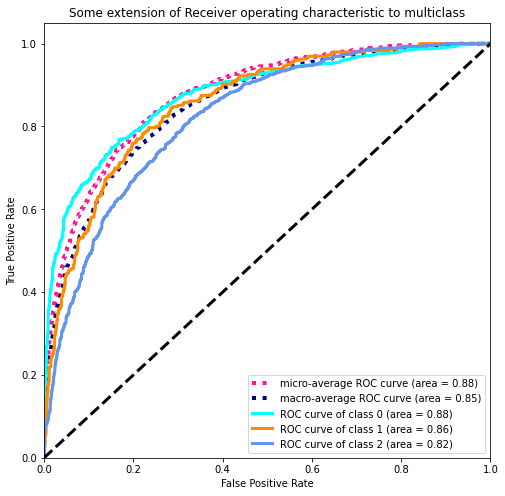

In [42]:
# CODE FROM https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

if device==torch.device("cuda"):
  y_score = scores.detach().cpu().numpy()
else:
  y_score = scores.detach().numpy()

y_test = np.array(pd.get_dummies(Y_test))
n_classes = 3

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
################################################################################

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(8,8))
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=3,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()

## Dynamic length of sequences

Using bucket iterator for dataloader and an embedding layer in our models.

First, I am going to redefine the models to add the embedding layer and to make it compatible with the batches for BucketIteratot.

In [43]:
# Create a bidirectional LSTM
class BRNN2(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, cell, embedding, dropout=0.3, attention=True):
        super(BRNN2, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.cell = cell
        self.bidirectional = True
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding))
        self.attention = attention
        self.scale = 1. / math.sqrt(hidden_size)
        if (cell == 'LSTM'):
          self.rnn = nn.LSTM(
              input_size, hidden_size, num_layers, bidirectional=True, dropout=dropout
          )
        else:
          self.rnn = nn.GRU(
              input_size, hidden_size, num_layers, bidirectional=True, dropout=dropout
          )
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        if (self.cell == 'LSTM'):
          out, hidden = self.rnn(x)
          hidden = hidden[1]
        else:
          out, hidden = self.rnn(x)

        if (self.attention==True):

            if (self.bidirectional==True):
                hidden = torch.cat([hidden[-1], hidden[-2]], dim=1) # concatinate the last 2 hidden cells (backward & forward)
            else:
                hidden = hidden[-1]

            query = hidden.unsqueeze(1) # [BxQ] -> [Bx1xQ]
            values = out
            keys = out.transpose(0,1).transpose(1,2) # [BxTxK] -> [BxKxT]
      
            attention_scores = torch.bmm(query, out.transpose(0,1).transpose(1,2)) # [Bx1xQ]x[BxKxT] -> [Bx1xT]
            attention_distribution = F.softmax(attention_scores.mul_(self.scale), dim=2) # scale, normalize

            out = torch.bmm(attention_distribution, out.transpose(0,1)).squeeze(1) #[Bx1xT]x[BxTxV] -> [BxV]

            out = self.fc(out)
        else:

            out = self.fc(out[-1, :, :])

        return out

Same for skip connections.

In [44]:
class skipBRNN2(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, cell, embedding, attention=True):
        super(skipBRNN2, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.cell = cell
        self.dropout = nn.Dropout(p=0.3)
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding))
        self.attention = attention
        self.bidirectional = True
        self.scale = 1. / math.sqrt(hidden_size)
        
        if (cell == 'LSTM'):
            rnn = nn.LSTM
        else:
            rnn = nn.GRU

        self.rnns = nn.ModuleList()
        for i in range(num_layers):
            input_size = input_size if i == 0 else hidden_size*2
            self.rnns.append(rnn(input_size, hidden_size, 1, bidirectional=True))
        
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):

        sent_variable = self.embedding(x)
        # print("after embedding", sent_variable.shape)

        # outputs = []
        for i in range(self.num_layers):
            if i != 0:
                sent_variable = self.dropout(sent_variable.detach())
            # print(i)
            # print("rnn input:" ,sent_variable.shape)
            out, hidden = self.rnns[i](sent_variable.detach())
            hidden = hidden[1]
            # print("rnn output:", out.shape)
            # outputs.append(out)
            # sent_variable = out
            if i == 0:
                sent_variable = out.detach()
            sent_variable = torch.cat((sent_variable,out.detach()),dim=0)

        if (self.attention==True):

            if (self.bidirectional==True):
                hidden = torch.cat([hidden[-1], hidden[-2]], dim=1) # concatinate the last 2 hidden cells (backward & forward)
            else:
                hidden = hidden[-1]

            # print("hidden", hidden.shape)
            query = hidden.unsqueeze(1) # [BxQ] -> [Bx1xQ]
            values = out
            # print("query", query.shape)
            # print("keys", out.shape)
            keys = out.transpose(0,1).transpose(1,2) # [BxTxK] -> [BxKxT]
            # print("keys", keys.shape)
            attention_scores = torch.bmm(query, out.transpose(0,1).transpose(1,2)) # [Bx1xQ]x[BxKxT] -> [Bx1xT]
            attention_distribution = F.softmax(attention_scores.mul_(self.scale), dim=2) # scale, normalize

            # out = out # [TxBxV] -> [BxTxV]
            # print("values", values.shape)
            out = torch.bmm(attention_distribution, out.transpose(0,1)).squeeze(1) #[Bx1xT]x[BxTxV] -> [BxV]
            # print("out", out.shape)
            out = self.fc(out)
        else:
            # print("out", out[-1, :, :].shape)
            out = self.fc(out[-1, :, :])

        return out

[link text](https://www.slideshare.net/fgodin/skip-residual-and-densely-connected-rnn-architectures)

Load the vectors.

In [45]:
glove_vocab  = vocab.Vectors(r"/content/drive/MyDrive/Colab Notebooks/Artificial Intelligence II/glove.twitter.27B.200d.txt.gz (Unzipped Files)/glove.twitter.27B.200d.txt")

100%|██████████| 1193514/1193514 [02:30<00:00, 7942.86it/s]


Create new datasets with only the useful columns.

In [73]:
df_train_new = df_train.drop(columns=['tweet', 'features'])

In [74]:
df_test_new = df_test.drop(columns=['tweet', 'features'])

https://gmihaila.medium.com/better-batches-with-pytorchtext-bucketiterator-12804a545e2a

Create the dataloaders for batches.

In [75]:
random.setstate(random.getstate())
text_field = Field(tokenize=nltk.word_tokenize,lower=True,sequential=True, fix_length=31) # tokenize text using word_tokenize and convert to numerical form using default parameters
label_field = Field(sequential=False, use_vocab=False)

fields = [('label',label_field),('clean_tweet',text_field)]

preprocessed_text = df_train_new['clean_tweet'].apply(lambda x: text_field.preprocess(x))
text_field.build_vocab(preprocessed_text,vectors=glove_vocab)

train_dataset = Dataset(
    examples=[Example.fromlist(list(r),fields) for i,r in df_train_new.iterrows()],
    fields=fields)

preprocessed_text_test = df_test_new['clean_tweet'].apply(lambda x: text_field.preprocess(x))
text_field.build_vocab(preprocessed_text_test,vectors=glove_vocab)

test_dataset = Dataset(
    examples=[Example.fromlist(list(r),fields) for i,r in df_test_new.iterrows()],
    fields=fields)



In [76]:
def train2(model, learning_rate, train_dataset, test_dataset, batch_size, epochs, device):
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    epoch_loss = []
    validation_loss = []

    train_loader, test_loader = BucketIterator.splits(
        datasets=(train_dataset, test_dataset),         # Datasets for iterator to draw data from
        batch_sizes=(batch_size, batch_size),           # Tuple of train and validation batch sizes.
        sort=False,                                     # Sort all examples in data using `sort_key`.
        device=device,                                  # Device to load batches on.
        sort_key=lambda x: len(x.clean_tweet),     # Function to use for sorting examples.
        shuffle=True,                                   # Shuffle data on each epoch run.
        sort_within_batch=True                          # Use `sort_key` to sort examples in each batch.
    )
    # Train Network
    for epoch in range(epochs):
        model.train()
        batch_losses = []
        for batch in train_loader:

            data = batch.clean_tweet
            targets = batch.label

            data = data.to(device=device).squeeze(1) # to device
            targets = targets.to(device=device) # to device

            # forward
            scores = model(data)
            loss = criterion(scores, targets)

            batch_losses.append(loss.item())

            # backward
            optimizer.zero_grad()
            loss.backward()

            # Clip params
            for param in model.parameters():
                if param.grad is None:
                    continue
                grad_val = torch.clamp(param.grad, -5, 5)

            # adam step
            optimizer.step()
            
        epoch_loss.append(sum(batch_losses)/len(train_loader))
        
        model.eval()
        batch_val_losses = []
        with torch.no_grad():
            for test_batch in test_loader:
                x = test_batch.clean_tweet
                y = test_batch.label
                x = x.to(device=device).squeeze(1)
                y = y.to(device=device)

                scores = model(x)
                loss = criterion(scores, y)

                batch_val_losses.append(loss.item())

            validation_loss.append(sum(batch_val_losses)/len(test_loader))

        print(f"Epoch {epoch:3}: Training Loss = {sum(batch_losses)/len(train_loader):.5f} Validation Loss = {validation_loss[epoch]:.5f}")
        # if (val_loss>validation_loss[epoch-1]+0.3): #early stopping
        n_epochs = epoch+1
        #     break 

    model.eval()
    total_scores = torch.empty((0,3)).to(device=device)
    labels = torch.empty((0)).to(device=device)

    with torch.no_grad():
        for test_batch in test_loader:
            x = test_batch.clean_tweet.to(device=device).squeeze(1)
            y = test_batch.label.to(device=device)

            scores = model(x)

            total_scores = torch.concat((total_scores, scores), 0)
            labels = torch.concat((labels, y), 0)
                    
    _, y_pred = total_scores.max(1)

    if device==torch.device("cuda"):
        y_pred =  y_pred.cpu()
        labels = labels.cpu()

    print("")
    precision, recall, f1, support = precision_recall_fscore_support(labels, y_pred)
    print(f"         precision\t  recall\t   f1\t    \tsupport")
    print(f"--------------------------------------------------------------")
    print(f"label 0 | {precision[0]*100:0.4f}\t {recall[0]*100:0.4f}\t {f1[0]*100:0.4f}\t {support[0]}")
    print(f"label 1 | {precision[1]*100:0.4f}\t {recall[1]*100:0.4f}\t {f1[1]*100:0.4f}\t {support[1]}")
    print(f"label 2 | {precision[2]*100:0.4f}\t {recall[2]*100:0.4f}\t {f1[2]*100:0.4f}\t {support[2]}")

    average = precision_recall_fscore_support(labels, y_pred, average='micro')
    print(f"micro   | {average[0]*100:0.4f}\t {average[1]*100:0.4f}\t {average[2]*100:0.4f}\t -")

    return epoch_loss, validation_loss, y_pred, scores


### Experimentation

In [77]:
set_seed()

# Hyperparameters
input_size = 200
num_layers = 2
hidden_size = 128
num_classes = 3
learning_rate = 0.01
batch_size = 64
cell = 'LSTM'
epochs = 3

# Initialize network
embedding = text_field.vocab.vectors
model = BRNN2(input_size, hidden_size, num_layers, num_classes, cell, embedding=embedding).to(device)
epoch_loss, validation_loss, y_pred, scores = train2(model, learning_rate, train_dataset, test_dataset, batch_size, epochs, device)

Epoch   0: Training Loss = 0.78514 Validation Loss = 0.69819
Epoch   1: Training Loss = 0.66414 Validation Loss = 0.67816
Epoch   2: Training Loss = 0.61838 Validation Loss = 0.66678

         precision	  recall	   f1	    	support
--------------------------------------------------------------
label 0 | 80.6163	 76.1502	 78.3197	 1065
label 1 | 61.7143	 36.4865	 45.8599	 296
label 2 | 65.1226	 77.8502	 70.9199	 921
micro   | 71.6915	 71.6915	 71.6915	 -


### Learning Curves

[0.7851437726020813, 0.6641406098604202, 0.6183834091424942]
[0.6981934772597419, 0.6781644307904773, 0.6667788525422415]


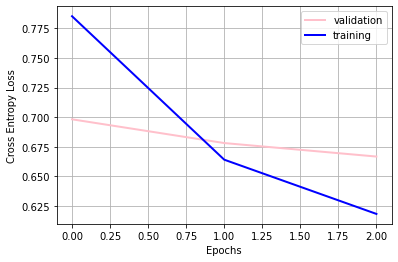

In [57]:
# plot
n_epochs = epochs
print(epoch_loss)
print(validation_loss)
fig, ax = plt.subplots()
ax.plot(np.arange(n_epochs), validation_loss, color="pink", lw=2, label='validation')
ax.plot(np.arange(n_epochs), epoch_loss, color="b", lw=2, label='training')

ax.set_xlabel('Epochs')
ax.set_ylabel('Cross Entropy Loss')

ax.grid()
ax.legend(loc=0)
plt.show()